# Voltage-Clamp Step Membrane Test

This project analyzes an membrane test sweeps generated by LTSpice from a circuit modeling a voltage-clamped neuron.

See the full website: **https://swharden.com/blog/2020-10-11-model-neuron-ltspice/**

![](../dev/diagram/whole-cell-voltage-clamp-diagram.png)

![](../models/single-electrode-memtest/screenshot.png)


## Environment Setup

In [1]:
import os
import ltspice
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import scipy.optimize
np.set_printoptions(suppress=True)

HERE = os.path.abspath(os.getcwd())
simFilePath = os.path.abspath(f"{HERE}/../models/single-electrode-memtest/memtest.raw")
assert os.path.isfile(simFilePath)

## Read, Scale, and Interpolate Model Data

We can read data right out of the LTSpice simulation file, but it is not evenly spaced.

In [2]:
l = ltspice.Ltspice(simFilePath)
l.parse()

#print(", ".join(l.getVariableNames()))
timesOriginal = l.getTime() * 1e3  # ms
Vcell = l.getData('V(vm)') * 1e3  # mV
Vcommand = l.getData('V(vc)') * 1e3  # mV
Iclamp = l.getData('I(Rf)') * 1e12  # pA

print(timesOriginal)

[  0.        0.10205   0.20445 ... 104.9596  104.9999  105.     ]


We will use Scipy's interpolation module to create a signal with evenly-spaced points

In [3]:
# interpolate data for 20 kHz sample rate
f = scipy.interpolate.interp1d(timesOriginal, Iclamp)
pointCount = int((timesOriginal[-1] - timesOriginal[0]) * 20) + 1
times = np.linspace(timesOriginal[0], timesOriginal[-1], pointCount)
Iclamp = f(times)
print(times)

[  0.     0.05   0.1  ... 104.9  104.95 105.  ]


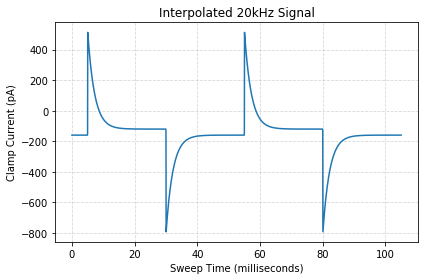

In [4]:
plt.figure(figsize=(6, 4))
plt.grid(ls='--', alpha=.5)
plt.title("Interpolated 20kHz Signal")
plt.plot(times, Iclamp)
plt.xlabel("Sweep Time (milliseconds)")
plt.ylabel("Clamp Current (pA)")
plt.tight_layout()
plt.savefig(f"{HERE}/mt1.png")
plt.show()

## Fix Single-Point Interpolation Error

There is a single bad data point where there is a sharp transition due to how the interpolation was performed. This error will not exist in real recorded data. I'll fix this manually.

In [5]:
Iclamp[100] = Iclamp[101] + (Iclamp[101] - Iclamp[102])
Iclamp[600] = Iclamp[601] + (Iclamp[601] - Iclamp[602])

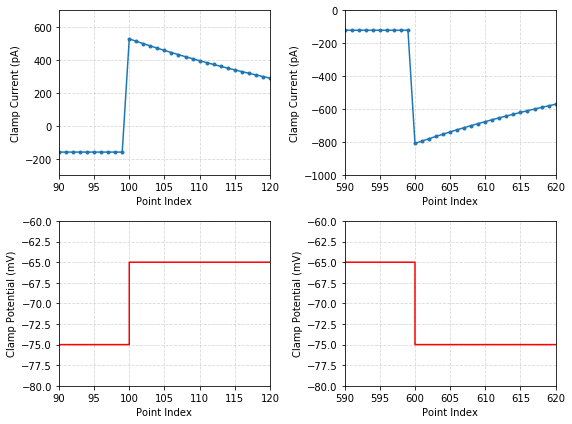

In [6]:
plt.figure(figsize=(8, 6))

plt.subplot(221)
plt.grid(ls='--', alpha=.5)
plt.plot(Iclamp, '.-')
plt.xlabel("Point Index")
plt.ylabel("Clamp Current (pA)")
plt.axis([90, 120, -300, 700])

plt.subplot(223)
plt.grid(ls='--', alpha=.5)
plt.plot(timesOriginal * 20, Vcommand, 'r-')
plt.xlabel("Point Index")
plt.ylabel("Clamp Potential (mV)")
plt.axis([90, 120, -80, -60])

plt.subplot(222)
plt.grid(ls='--', alpha=.5)
plt.plot(Iclamp, '.-')
plt.xlabel("Point Index")
plt.ylabel("Clamp Current (pA)")
plt.axis([590, 620, -1000, 0])

plt.subplot(224)
plt.grid(ls='--', alpha=.5)
plt.plot(timesOriginal * 20, Vcommand, 'r-')
plt.xlabel("Point Index")
plt.ylabel("Clamp Potential (mV)")
plt.axis([590, 620, -80, -60])


plt.tight_layout()
plt.show()

## Isolate Curve of Interest

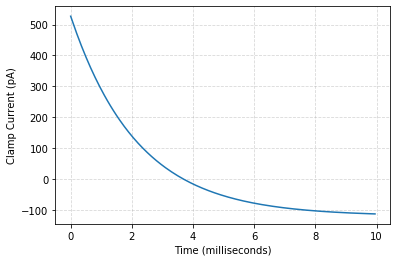

In [7]:
curve = Iclamp[100:300]
curveTimes = times[:len(curve)]

plt.figure(figsize=(6, 4))
plt.grid(ls='--', alpha=.5)
plt.plot(curveTimes, curve, '-')
plt.xlabel("Time (milliseconds)")
plt.ylabel("Clamp Current (pA)")
plt.savefig(f"{HERE}/mt1.png")
plt.show()

## Fit an Exponential Curve

In [8]:
def monoExp(t, m, tau, b):
    return m * np.exp(-t/tau) + b

(m, tau, b), cv = scipy.optimize.curve_fit(monoExp, curveTimes, curve, (2000, .1, 50))
print(f"I = {m:.03f} * exp(-t / {tau:.03f}) + {b:.03f}")

I = 647.668 * exp(-t / 2.184) + -120.291


## Prepare Variables (with proper units)

For simplicity let's create variable names consistent with the diagram:

![](../dev/diagram/voltage-clamp-square-membrane-test.png)

In [10]:
Iss = b*1e-12
print(f"Iss: {Iss*1e12:.03f} pA")

Iprev = Iclamp[99]*1e-12
print(f"Iprev: {Iprev*1e12:.03f} pA")

Idss = Iss - Iprev
print(f"dIss: {Idss*1e12:.03f} pA")

Ipeak = (m + b)*1e-12
print(f"Ipeak: {Ipeak*1e12:.03f} pA")

dI = Ipeak - Iprev
print(f"dI: {dI*1e12:.03f} pA")

dV = 10e-3
print(f"dV: {dV*1e3:.03f} mV")

tauClamp = tau*1e-3
print(f"tauClamp: {tauClamp*1e3:.03f} ms")

Iss: -120.291 pA
Iprev: -159.715 pA
dIss: 39.424 pA
Ipeak: 527.377 pA
dI: 687.092 pA
dV: 10.000 mV
tauClamp: 2.184 ms


## Calculate Ra

In [11]:
# E = I * R
# ΔV = ΔI * R
# R = ΔV / ΔI
# Ra = ΔV / (Ipeak - Iss)
# Ra = ΔV / I0

Ra = dV / dI
print(f"Ra: {Ra*1e-6:f} MΩ")

Ra: 14.554091 MΩ


## Calculate Rm

LTSpice warning: if grounding Rm through a voltage source make sure its series resistance is large (999G)

In [13]:
# V = I * R
# I = V / R
# ΔI = ΔV / R
# R * ΔI = ΔV
# (Ra + Rm) * ΔI = ΔV
# Ra * ΔI + Rm * ΔI = ΔV
# Rm * ΔI = ΔV - Ra * ΔI
# Rm = (ΔV - Ra * ΔI) / ΔI

Rm = (dV - Ra * Idss) / Idss
print(f"Rm: {Rm*1e-6:f} MΩ")

Rm: 239.096820 MΩ


## Calculate Cm

Remember that Ra and Rm in parallel so to combine them take the reciprocal of the sum of their reciprocals.

In [15]:
# tau = R * C
# C = tau / R
Cm = tauClamp / (1/(1/Ra + 1/Rm))
print(f"Cm: {Cm*1e12:f} pF")

Cm: 159.197885 pF


## Summary

Metric | Model | Measured | Error
---|---|---|---
Ra|15 MΩ|14.55 MΩ|3%
Rm|500 MΩ|484.96 MΩ|3%
Cm|150 pF|159.20 pF|6%

## Measuring Charge (Q)

This is an alternative (inferior) way to estimate Cm, but it's often used historically so let's try to measure it here.

![](../dev/diagram/voltage-clamp-square-membrane-test.png)

AUC = 1429.295 pA*ms (fC)
Cm = 142.929 pF


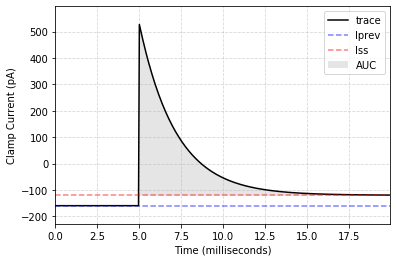

In [150]:
segment = Iclamp[:400]*1e-12
segmentTimes = np.arange(len(segment))/20
measure = np.array(segment) - Iss
measure[:100] = np.nan
sampleRate = 20_000
auc = np.nansum(measure) / sampleRate
print(f"AUC = {auc*1e15:.03f} pA*ms (fC)")

# Q = C * dV
# C = Q / dV
Cm = auc / dV
print(f"Cm = {Cm*1e12:.03f} pF")

plt.figure(figsize=(6, 4))
plt.grid(ls='--', alpha=.5)
plt.plot(segmentTimes, segment*1e12, 'k', label="trace")
plt.axhline(Iprev*1e12, color="b", ls="--", alpha=.5, label="Iprev")
plt.axhline(Iss*1e12, color="r", ls="--", alpha=.5, label="Iss")
plt.fill_between(segmentTimes, 
                 np.full(len(measure), Iss)*1e12, 
                 (measure + Iss)*1e12,
                 color='k', alpha=.1, lw=0, label="AUC")
plt.margins(0, .1)
plt.legend()
plt.ylabel("Clamp Current (pA)")
plt.xlabel("Time (milliseconds)")
plt.savefig(f"{HERE}/mt2.png")
plt.show()